# Sentiment Analysis - Spanish Movie Reviews
**By Zach Friedman**, zacheryfriedman@my.unt.edu

In [20]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 9.8 MB 7.8 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 14.0 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [4]:
import pandas as pd
import nltk
import numpy as np
from spellchecker import SpellChecker
import swifter
import pickle
import regex as re

# NLTK VADER imports
from nltk.tokenize import WordPunctTokenizer, sent_tokenize
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

import transformers
from transformers import AutoTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from datasets import load_metric
from huggingface_hub import notebook_login
from transformers import TrainingArguments, Trainer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /home/zach/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zach/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/zach/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /home/zach/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zach/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/zach/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Preliminary Model: VADER Sentiment Analysis Tool
> https://github.com/cjhutto/vaderSentiment

In [3]:
df = pd.read_csv('./sanitized_v2.csv')

In [2]:
def analyze(doc):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(doc)

def preprocessor(doc):
    sentences = sent_tokenize(doc)
    spellchecker = SpellChecker(language='en')
    lemmatizer = WordNetLemmatizer()
    
    sentences = [[word.lower() for word in sent.split() if word not in stopwords.words('english')] for sent in sentences]
    corrected = [[spellchecker.correction(word) for word in sentence] for sentence in sentences]
    remove_none = [[word for word in sentence if word is not None] for sentence in corrected]
    lemmatized = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in remove_none]

    return [" ".join(sent) for sent in lemmatized]

In [12]:
df['review_en'] = df['review_en'].swifter.apply(preprocessor) # Apply sentence tokenization to each English review in the dataframe

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

In [33]:
df.to_csv('sanitized_v2.csv')

In [3]:
df.iloc[0]

Unnamed: 0                                                     0
review_en      One of the other reviewers has mentioned that ...
review_es      Uno de los otros críticos ha mencionado que de...
sentiment                                               positive
sentimiento                                             positivo
Name: 0, dtype: object

In [32]:
labels = [] # A list to hold the predicted labels for each review

for i in range(len(df)): # For each review in the dataframe...
    review_sentiment = [] # A list to hold the sentiments of each sentence in a review

    for sent in df['review_en'].iloc()[i]: # For each sentence in a review...

        analysis = analyze(sent) # Apply the sentiment intensity analyzer to each sentence

        subset = ['neg', 'pos'] # We only care about the negative and positive scores, since the dataset does not include neutral labels
        subset_dict = {key: value for key, value in analysis.items() if key in subset} # Create a subset dictionary with 'neg' and 'pos' key-value pairs

        sentiment = max(subset_dict, key=subset_dict.get) # Get the maximum of the 'neg' and 'pos' scores

        review_sentiment.append(sentiment) # Append the sentiment for the current sentence to the list of sentiments

    sentiment_counts = Counter(review_sentiment) # Count the number of 'neg' and 'pos' in the list of sentiments

    # Find the most common sentiment in the list of sentiments for a review and append the appropriate label to the list of prediction labels
    if sentiment_counts.most_common(1)[0][0] == 'neg':
        labels.append('negative')
    else:
        labels.append('positive')

predictions = pd.DataFrame(data=labels, columns=["prediction"])

predictions

KeyboardInterrupt: 

In [ ]:
predictions.to_csv("predictions_v2.csv")

In [ ]:
merged = pd.merge(df['sentiment'], predictions['prediction'], left_index=True, right_index=True)

boolean_mask = merged.iloc[:,0] == merged.iloc[:,1]

vader_accuracy = boolean_mask.mean()

print(f"VADER accuracy: {vader_accuracy}")

## Multinomial Naive Bayes

In [61]:
fresh_df = pd.read_csv('./sanitized_v3.csv')

fresh_df = fresh_df.drop(['Unnamed: 0'], 1)
fresh_df = fresh_df.drop(['review_es'], 1)
fresh_df = fresh_df.drop(['sentimiento'], 1)

In [62]:
fresh_df.head()

,review_en,sentiment
0,"['one', 'reviewer', 'mentioned', 'watching', '...",positive
1,"['wonderful', 'little', 'production', 'filming...",positive
2,"['thought', 'wonderful', 'way', 'spend', 'time...",positive
3,"['basically', 'family', 'little', 'boy', 'jake...",negative
4,"['petter', 'mattei', 'love', 'time', 'money', ...",positive


In [49]:
def replace_pattern(pattern):
    return ''

def insert_space(pattern):
    return pattern.group() + ' '

def preprocessor(df):
    tokenizer = WordPunctTokenizer()
    lemmatizer = WordNetLemmatizer()
    
    hyperlinks = r'https?://[A-Za-z0-9./]+'
    emails = r'\S+@\S+'
    sentence = r'\.(?=[A-Z])'
    
    df['review_en'] = df['review_en'].apply(lambda x: re.sub(hyperlinks, replace_pattern, x))
    df['review_en'] = df['review_en'].apply(lambda x: re.sub(emails, replace_pattern, x))
    df['review_en'] = df['review_en'].apply(lambda x: re.sub(sentence, insert_space, x))
    
    tokens = tokenizer.tokenize(doc)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    
    return tokens

In [36]:
fresh_df.to_csv("sanitized_v2.csv")

In [73]:
X = fresh_df.iloc[:, :-1]
y = fresh_df.iloc[:, -1]

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80/20 split

X_train = X_train['review_en'].tolist() # Convert English reviews in X_train to a list of strings
X_test = X_test['review_en'].tolist() # Convert reviews in X_test to a list of strings

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [64]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'negative': 0, 'positive': 1}


In [80]:
mnb = MultinomialNB() # Instantiate a Multinomial Naive Bayes classifier object

mnb.fit(X_train, y_train) # Fit the classifier to the object

yhat = mnb.predict(X_test) # Create a set of predictions on the test set

mnb_accuracy = accuracy_score(y_test, yhat) # Generate an accuracy score based on the ground truth 'y_test' and the list of predictions 'yhat'

In [81]:
print(f"MultinomialNB accuracy: {mnb_accuracy}")

MultinomialNB accuracy: 0.867


- Bernoulli NB
- Logistic Regression
- Preprocessing
- Check related works
- Tune a model for the dataset.

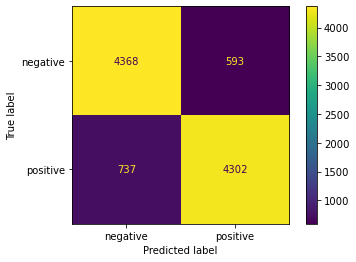

In [82]:
cm1 = confusion_matrix(y_test, yhat)

cm1_display = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['negative', 'positive']) # Create a prettier version of the confusion matrix. 

cm1_display.plot()

In [83]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4961
           1       0.88      0.85      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## Bernoulli Naive Bayes

In [84]:
bnb = BernoulliNB()

bnb.fit(X_train, y_train)

yhat2 = bnb.predict(X_test)

bnb_accuracy = accuracy_score(y_test, yhat2)

In [85]:
print(f"BernoulliNB accuracy: {bnb_accuracy}")

BernoulliNB accuracy: 0.8517


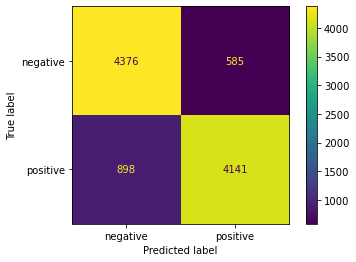

In [86]:
cm2 = confusion_matrix(y_test, yhat2)

cm2_display = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['negative', 'positive'])

cm2_display.plot()

In [87]:
print(classification_report(y_test, yhat2))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      4961
           1       0.88      0.82      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



## Logistic Regression

In [88]:
lr = LogisticRegression(solver="newton-cg")

lr.fit(X_train, y_train)

yhat3 = lr.predict(X_test)

lr_accuracy = accuracy_score(y_test, yhat3)

In [89]:
print(f"Logistic Regression accuracy: {lr_accuracy}")

Logistic Regression accuracy: 0.8968


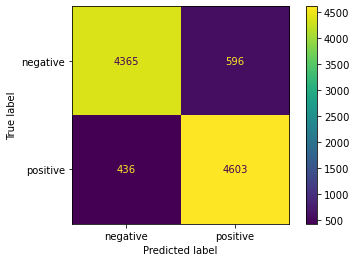

In [90]:
cm3 = confusion_matrix(y_test, yhat3)

cm3_display = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=['negative', 'positive'])

cm3_display.plot()

In [91]:
print(classification_report(y_test, yhat3))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Save the best performing model

In [92]:
with open('LogReg.pkl', 'wb') as f:
    pickle.dump(lr, f)

In [93]:
with open('Vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [94]:
pipeline = Pipeline([
    ('preprocessing', FunctionTransformer(preprocessor)),
    ('label_encoder', label_encoder),
    ('classifier', lr)
])

set_config(display="diagram")
pipeline

Pipeline(steps=[('preprocessing',
                 FunctionTransformer(func=<function preprocessor at 0x7f2535ff6670>)),
                ('label_encoder', LabelEncoder()),
                ('classifier', LogisticRegression(solver='newton-cg'))])